<a href="https://colab.research.google.com/github/mhabib80/Spotify-API/blob/master/Copy_of_Spotify_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries / API Connection

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [ ]:
# Exchange Client ID/Secret for a token
client_id = ''
client_secret = ''
TOKEN_URL = 'https://accounts.spotify.com/api/token'

body = {'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret}
auth_response = requests.post(TOKEN_URL, data=body)
token = auth_response.json()['access_token']
header = {'Authorization': f'Bearer {token}'}

# Enter Artists

In [ ]:
artists = input('Enter Artist Names separated by a comma & space: ').split(', ')
artists

Enter Artist Names separated by a comma & space: led zeppelin, alice in chains


['led zeppelin', 'alice in chains']

# API Data

In [ ]:
albums_df_list = []

for artist in artists:
  # Get Artist ID
  r = requests.get(f'https://api.spotify.com/v1/search?type=artist&q={artist}', headers=header)
  artist_id = r.json()['artists']['items'][0]['id']


  # Get Artist Albums
  r = requests.get (f' https://api.spotify.com/v1/artists/{artist_id}/albums?&market=US&limit=50', headers=header)
  albums = r.json()['items']

  # remove live and remix albums
  exclusions = ['live', 'remix', 'rmx', 'mix', 'remaster']
  albums = [album for album in albums if not any(excl in album['name'].lower() for excl in exclusions)]

  # Get Album data
  for album in albums:
    album_name = album['name']
    album_id = album['id']
    album_release_date = album['release_date']
    artist_name = album['artists'][0]['name']

    #Get a string of track ids of each album tracks
    if artist.casefold() == artist_name.casefold():
      r = requests.get(f'https://api.spotify.com/v1/albums/{album_id}/tracks?&market=US&limit=50', headers=header)
      album_tracks = r.json()['items']
      track_ids = ','.join(track['id'] for track in album_tracks)
      track_names = [track['name'] for track in album_tracks]
      
      #Get audio features of all album tracks
      r = requests.get(f'https://api.spotify.com/v1/audio-features?&ids={track_ids}', headers=header)
      album_tracks_audio_features = r.json()['audio_features']
      album_df = pd.DataFrame(album_tracks_audio_features).assign(track_name=track_names, album_name = album_name, album_release_date=album_release_date, artist = artist_name )
      albums_df_list.append(album_df)

#Combine all artist dataframes into one, drop unnecessary columns and duplicates
df = pd.concat(albums_df_list).drop(['id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1).drop_duplicates(subset = ['track_name', 'duration_ms'], keep='first')
# Remove other artists 
df = df[df['artist'].str.lower().isin(artists)].reset_index(drop=True)
# Change Keys numbers to alphabets
keys = {0:'C', 1:'C#', 2:'D', 3:'D#', 4:'E', 5:'F', 6:'F#', 7:'G', 8: 'G#', 9:'A', 10:'A#', 11:'B'}
df['key'] = df['key'].astype(int).map(keys)
# Change the mode coding
modes = {1:'Major', 0:'Minor'}
df['mode'] = df['mode'].map(modes)
# Change the album release date to datetime
df['album_release_date'] = pd.to_datetime(df['album_release_date']).dt.year
# Capitalize column headers
df.columns = [col.title() for col in df.columns]
# Convert non-numeric columns to categorical
for col in ['Mode', 'Key', 'Time_Signature', 'Artist']:
  df[col] = df[col].astype('category')
df.head()

,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_Ms,Time_Signature,Track_Name,Album_Name,Album_Release_Date,Artist
0,0.358,0.840,G,-9.467,Major,0.0736,0.000007,0.0841,0.567,0.536,96.540,191560,4,"Good Times Bad Times - Live: O2 Arena, London ...",Celebration Day,2012,Led Zeppelin
1,0.343,0.660,D,-10.646,Major,0.0412,0.001060,0.2010,0.991,0.515,95.273,344560,4,"Ramble On - Live: O2 Arena, London - December ...",Celebration Day,2012,Led Zeppelin
2,0.202,0.847,G,-9.943,Major,0.0834,0.000180,0.0176,0.994,0.471,168.300,353400,4,"Black Dog - Live: O2 Arena, London - December ...",Celebration Day,2012,Led Zeppelin
3,0.241,0.873,C,-10.270,Major,0.0625,0.000054,0.4980,0.747,0.342,99.141,670787,4,"In My Time of Dying - Live: O2 Arena, London -...",Celebration Day,2012,Led Zeppelin
4,0.442,0.840,G,-9.332,Major,0.0528,0.000119,0.5130,0.768,0.472,89.958,400427,4,"For Your Life - Live: O2 Arena, London - Decem...",Celebration Day,2012,Led Zeppelin


In [ ]:
df.Artist.unique()

['Led Zeppelin', 'Alice In Chains']
Categories (2, object): ['Alice In Chains', 'Led Zeppelin']

In [ ]:
df.to_csv('Spotify_data_Led_Zeppelin.csv')

# Visualization

## Data Exploration

In [ ]:
# Set visualization parameters
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.linewidth']=0.5
plt.rcParams['xtick.color']='grey'
plt.rcParams['ytick.color']='grey'
plt.rc('axes.spines', left=True, top=False, right=False)
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['axes.titlelocation']= 'left' 
plt.rcParams['axes.titlepad'] = 10

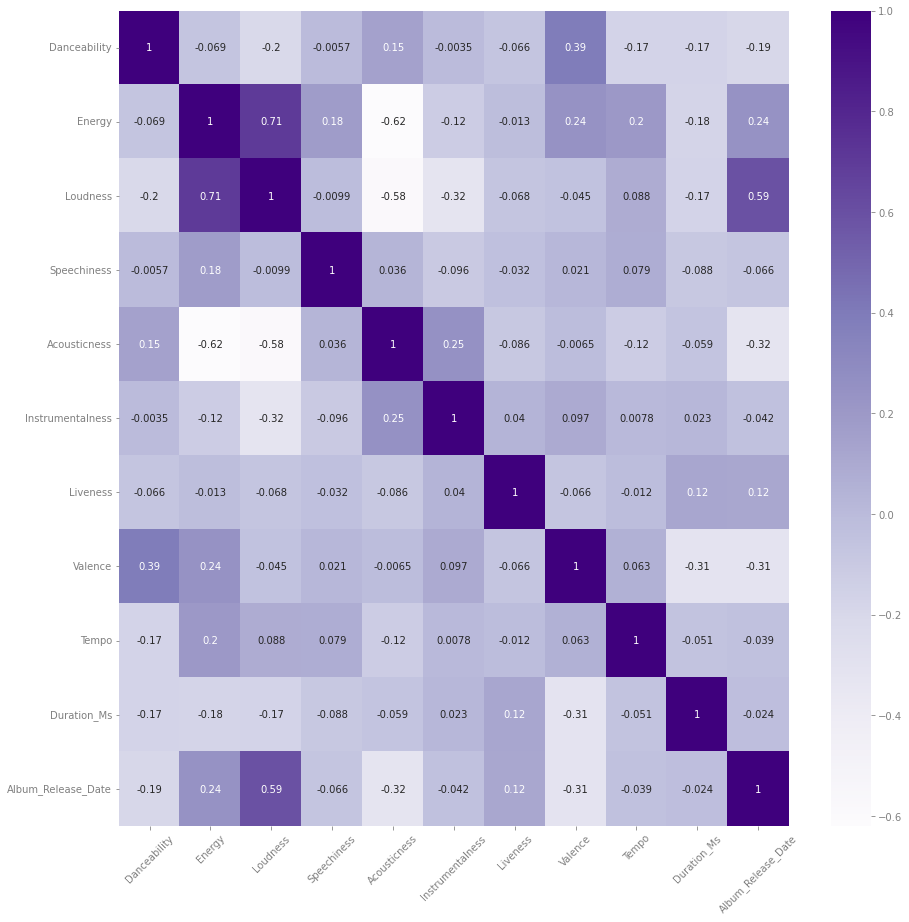

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Purples)
plt.xticks(rotation = 45);

In [ ]:
# Stack the df for Seaborn
scaled_categories = ['Artist','Danceability', 'Energy', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence']

stacked_df = df[scaled_categories].melt(id_vars='Artist')
stacked_df.variable = stacked_df.variable.str.title()
stacked_df

,Artist,variable,value
0,Led Zeppelin,Danceability,0.358
1,Led Zeppelin,Danceability,0.343
2,Led Zeppelin,Danceability,0.202
3,Led Zeppelin,Danceability,0.241
4,Led Zeppelin,Danceability,0.442
...,...,...,...
2774,Alice In Chains,Valence,0.285
2775,Alice In Chains,Valence,0.564
2776,Alice In Chains,Valence,0.385
2777,Alice In Chains,Valence,0.381


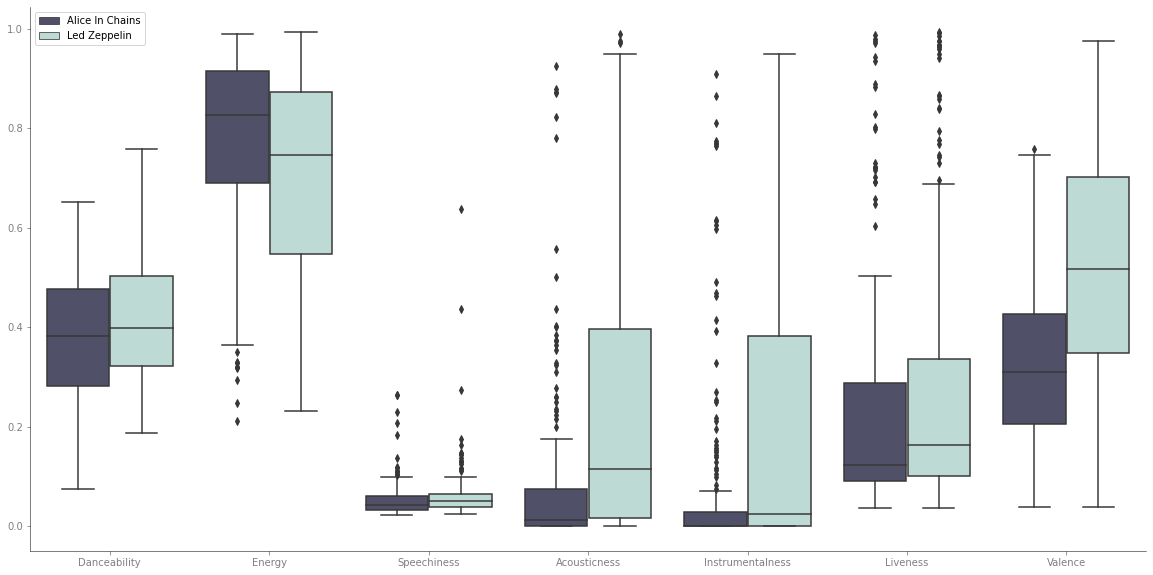

In [ ]:
colors = ["#4C4C6D", "#B8DFD8"]
fig, ax = plt.subplots(figsize=(20,10))
sns.set_palette(sns.color_palette(colors))
sns.boxplot(x = 'variable', y='value', hue='Artist', data = stacked_df,  ax = ax)
plt.legend(title=None)
# plt.xticks(labels=)
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None);

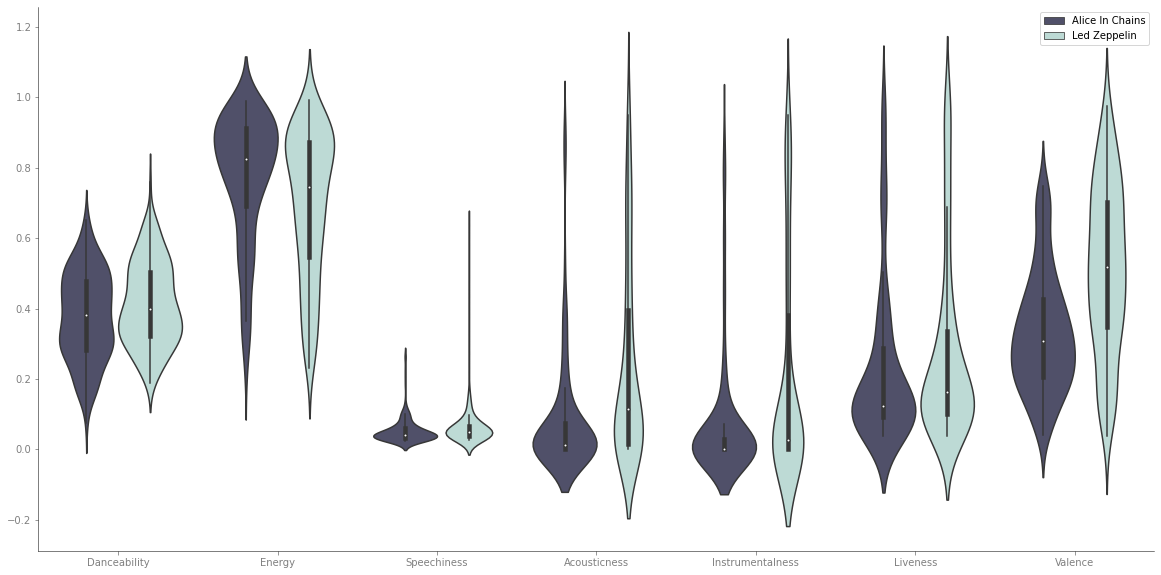

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.violinplot(x = 'variable', y='value', hue='Artist', data = stacked_df,  ax = ax)
plt.legend(title=None)
plt.xlabel(xlabel=None)
plt.ylabel(ylabel=None);

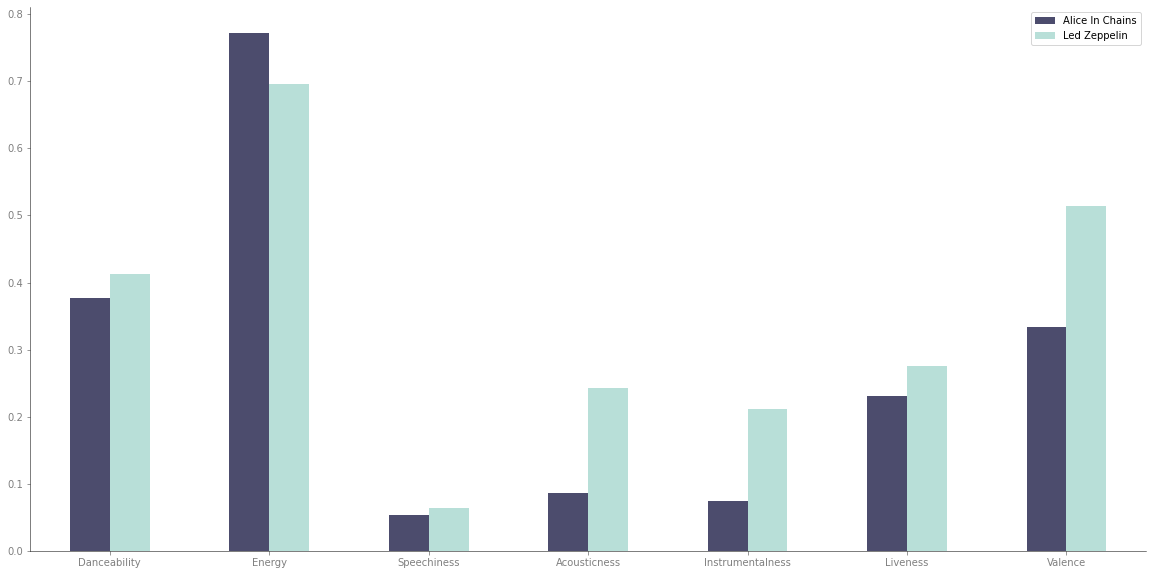

In [ ]:
df[scaled_categories].groupby('Artist').mean().T.plot(kind='bar', figsize=(20,10), color=colors)
plt.legend(title=None)
plt.xticks(rotation = 0);

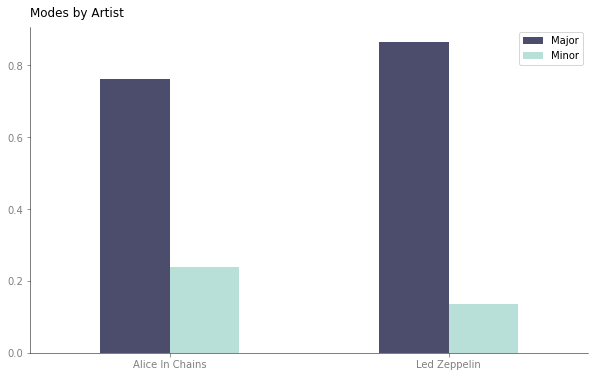

In [ ]:
modes = df.groupby(['Artist', 'Mode']).Mode.count().unstack()
# normalize values
modes_norm = modes.div(modes.sum(1), axis=0)
modes_norm.plot(kind='bar', figsize=(10,6))
plt.legend(title=None)
plt.xlabel(xlabel=None)
plt.xticks(rotation = 0)
plt.title(label='Modes by Artist');

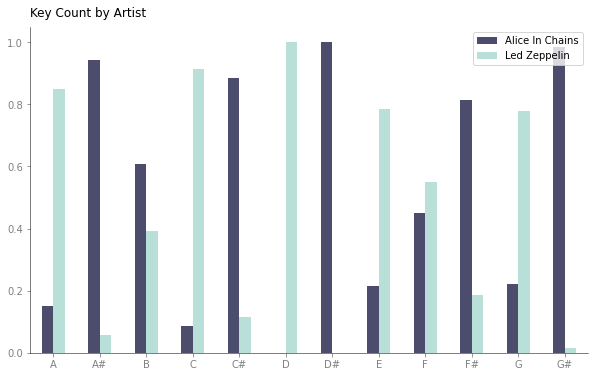

In [ ]:
keys = df.groupby(['Key', 'Artist']).Key.count().unstack()
keys_norm = keys.div(keys.sum(1), axis=0)
keys_norm.plot(kind='bar', figsize=(10,6))
plt.legend(title=None)
plt.xlabel(xlabel=None)
plt.xticks(rotation = 0)
plt.title(label='Key Count by Artist');

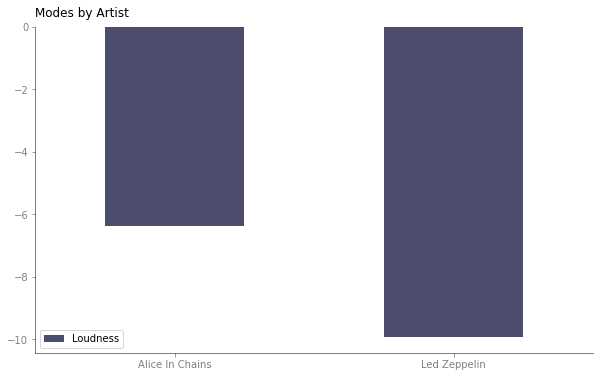

In [ ]:
loudness = df.groupby('Artist').Loudness.mean()
loudness.plot(kind='bar', figsize=(10,6))
plt.legend(title=None)
plt.xlabel(xlabel=None)
plt.xticks(rotation = 0)
plt.title(label='Modes by Artist');

## Radar Chart

In [ ]:
# df = pd.read_csv('Spotify_data.csv', index_col=0)
df = df[scaled_categories].groupby('Artist').mean().reset_index()
df

,Artist,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
0,Alice In Chains,0.376846,0.771985,0.053256,0.085981,0.074817,0.230680,0.333219
1,Led Zeppelin,0.412402,0.696668,0.063171,0.242031,0.210807,0.275515,0.513957


In [ ]:
len(df)

1

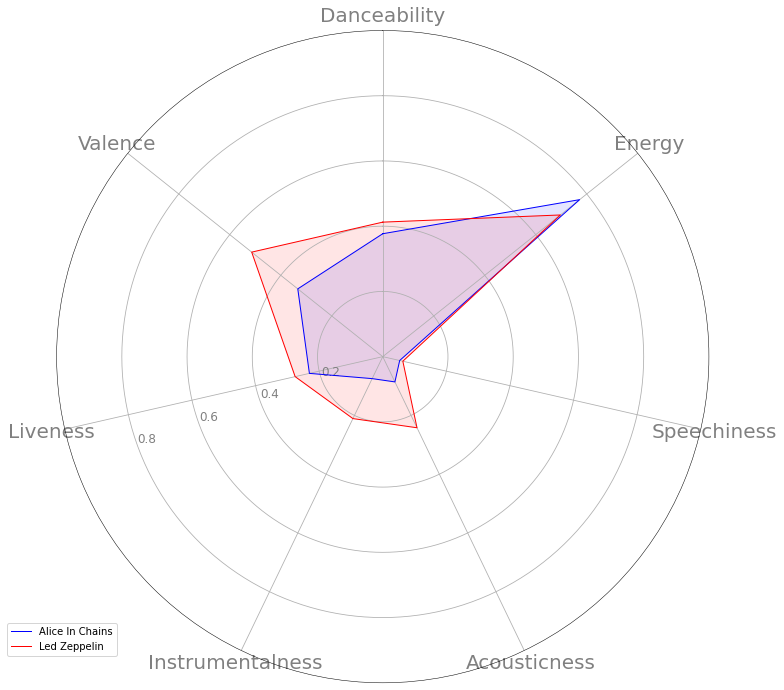

In [ ]:
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize = (12,12))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, fontsize=20)
 
# Draw ylabels
ax.set_rlabel_position(250)
plt.yticks([0.2,0.4,0.6,0.8], ['0.2', '0.4', '0.6', '0.8'], color="grey", size=12)
plt.ylim(0,1)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 

# Ind1
values=df.loc[0].drop('Artist').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.loc[0,'Artist'], color='b')
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
if len(df) ==2:
  values=df.loc[1].drop('Artist').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.loc[1,'Artist'], color='r')
  ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

## Plotly

In [ ]:
# df = pd.read_csv('Spotify_data.csv', index_col=0)
df.set_index('Artist', inplace=True, drop=True)
df

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Liveness,Valence
Artist,,,,,,,
Alice In Chains,0.376846,0.771985,0.053256,0.085981,0.074817,0.230680,0.333219
Led Zeppelin,0.412402,0.696668,0.063171,0.242031,0.210807,0.275515,0.513957


In [ ]:
import plotly.graph_objects as go

categories = list(df)

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df.iloc[0].to_list(),
      theta=categories,
      fill='toself',
      name=df.index[0]
))

if len(df)==2:
  fig.add_trace(go.Scatterpolar(
        r=df.iloc[1].to_list(),
        theta=categories,
        fill='toself',
        name=df.index[1]
  ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.update_layout(
    # autosize=False,
    width=1000,
    height=500)

fig.show()